# Capstone Assignment: Comparing Recommendation Systems

**Overview**: In this Capstone Assignment, my goal is to compare the performance of various recommendation systems, namely Content-Based Filtering, Collaborative Filtering, and Hybrid Recommendation Systems. I will utilize datasets related to book ratings. 



### Getting Started

The datasets are from the Goodreads Book Grapgh Datasets. The ratings.csv dataset consists of ratings given to various books by Goodreads users. The books.csv dataset provides information about each book that is rated including the title, original publication year, ISBN, average rating, and more. These datasets can be found [here](https://cseweb.ucsd.edu/~jmcauley/datasets/goodreads.html#datasets) Goodreads has asked for the following citations to be provided upon use:
- Mengting Wan, Julian McAuley, "Item Recommendation on Monotonic Behavior Chains", in RecSys'18. [bibtex]
- Mengting Wan, Rishabh Misra, Ndapa Nakashole, Julian McAuley, "Fine-Grained Spoiler Detection from Large-Scale Review Corpora", in ACL'19. [bibtex]

It should be noted that the original datasets from the Goodreads website provided above were too large to load onto my computer. Therefore, I am using modified versions of the datasets from the GitHub user zygmuntz through their goodbooks-10k repository which can be found [here](https://github.com/zygmuntz/goodbooks-10k). The ratings.csv and books.csv datasets are what I will use. It should be noted that the modifications to the datasets are necessary for modeling. To be specific, the original ratings dataset consisted of Goodreads-specific user and book IDs. The modified ratings dataset gives a more uniform identification to the books and users. These identification numbers were provided by Goodreads with the purpose of being combined and added to the ratings dataset.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the Goodreads link above, and examine the **Overview** section of the page.

All the data was collected in late 2017 from goodreads.com. Three groups of datasets were collected. These datasets include meta-data of the books, user-book interactions, and users' detailed book reviews. All three datasets can be joined on book, user, and review IDs. 

The ratings.csv dataset provides the ratings given to multiple different books from multiple different users. Each book has been reviewed by multiple users and each user has reviewed multiple books. In total, there are 3 columns (user_id, book_id, and rating) and 100,000 rows. The books.csv dataset provides information on each book that has been reviewed. 10,000 books have been reviewed. 

### Problem 2: Read in the Data

Use pandas to read in the datasets `ratings.csv` and `books.csv`and assign to a meaningful variable name.

In [1]:
# Import the appropriate libraries

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import time
import hnswlib
from annoy import AnnoyIndex
from sklearn.ensemble import RandomForestClassifier
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering

import itertools
from collections import defaultdict
from joblib import Parallel, delayed
from scipy.stats import randint, uniform
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import precision_score, recall_score
from surprise.model_selection import cross_validate, RandomizedSearchCV

In [2]:
# Load the data

ratings = pd.read_csv('data/ratings.csv')
books = pd.read_csv('data/books.csv')


In [3]:
# Sample the first 5 rows of the full dataset

ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [4]:
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


### Problem 3: Understanding the Features Through Data Cleaning


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# Goodreads Book Graph Data:
1 - User-ID : Gives anonymity to each Goodreads user. With the User-ID one can search through the user_id_map.csv dataset to find the users' Goodreads user_id. (numeric)
2 - Book-ID : Allows each book to be identifiable while also keeping the data numeric and simple for modeling. With the Book-ID one can search through the book_id_map.csv dataset to find the books' Goodreads user_id. One can also search the books.csv for the specific title of the book and information about it. (numeric)
Output variable (desired target):
21 - Rating - How much does the member like the book? (numeric: 1-5 with 5 being the highest appreciation)
```



There are no missing values or duplicate columns in the ratings.csv dataset. The books.csv dataset did have missing values but no duplicate values. The missing values/rows in the books.csv dataset have been dropped and the index has been reset.

In [5]:
# Check/count the missing data in the rtaings dataset

missing_rates = ratings.isnull().sum()
missing_rates

user_id    0
book_id    0
rating     0
dtype: int64

In [6]:
# Check/count the missing data in the books dataset

missing_books = books.isnull().sum()
missing_books

book_id                         0
goodreads_book_id               0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

In [7]:
# Drop missing data in the books dataset

books_cleaned = books.dropna()
books_cleaned

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,9995,15613,15613,2764239,199,1416523723,9.781417e+12,Herman Melville,1924.0,"Billy Budd, Sailor",...,10866,12110,681,1478,2225,3805,2985,1617,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9995,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
9996,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
9997,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...


In [8]:
# Check for duplicate data in the rtaings dataset

duplicates_rates = ratings.duplicated().sum()
duplicates_rates

0

In [9]:
# Check for duplicate data in the books dataset

duplicates_books = books_cleaned.duplicated().sum()
duplicates_books

0

In [10]:
books_n = books_cleaned.reset_index(drop=True)
books_n

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7855,9995,15613,15613,2764239,199,1416523723,9.781417e+12,Herman Melville,1924.0,"Billy Budd, Sailor",...,10866,12110,681,1478,2225,3805,2985,1617,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7856,9996,7130616,7130616,7392860,19,441019455,9.780441e+12,Ilona Andrews,2010.0,Bayou Moon,...,17204,18856,1180,105,575,3538,7860,6778,https://images.gr-assets.com/books/1307445460m...,https://images.gr-assets.com/books/1307445460s...
7857,9997,208324,208324,1084709,19,067973371X,9.780680e+12,Robert A. Caro,1990.0,Means of Ascent,...,12582,12952,395,303,551,1737,3389,6972,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...
7858,9998,77431,77431,2393986,60,039330762X,9.780393e+12,Patrick O'Brian,1977.0,The Mauritius Command,...,9421,10733,374,11,111,1191,4240,5180,https://images.gr-assets.com/books/1455373531m...,https://images.gr-assets.com/books/1455373531s...


### Problem 4: Perform Exploratory Data Analysis (EDA)


Examine the data and perform EDA to identify patterns in the data.

In [11]:
# Find the top 50 reviewed books

frequent_books = books_cleaned[['title', 'ratings_count', 'original_publication_year']].sort_values('ratings_count', ascending = False).reset_index()
frequent_books = frequent_books.drop(['index'], axis=1)
frequent_books = frequent_books.head(50)
frequent_books

,title,ratings_count,original_publication_year
0,"The Hunger Games (The Hunger Games, #1)",4780653,2008.0
1,Harry Potter and the Sorcerer's Stone (Harry P...,4602479,1997.0
2,"Twilight (Twilight, #1)",3866839,2005.0
3,To Kill a Mockingbird,3198671,1960.0
4,The Great Gatsby,2683664,1925.0
5,The Fault in Our Stars,2346404,2012.0
6,The Hobbit,2071616,1937.0
7,The Catcher in the Rye,2044241,1951.0
8,Pride and Prejudice,2035490,1813.0
9,"Angels & Demons (Robert Langdon, #1)",2001311,2000.0


In [12]:
# Find the top 50 reviewers

frequent_users = ratings[['user_id']].value_counts().to_frame().reset_index()
frequent_users.rename(columns={0:'count'}, inplace=True)
frequent_users = frequent_users.head(50)
frequent_users

,user_id,count
0,30944,200
1,12874,200
2,52036,199
3,12381,199
4,28158,199
5,45554,197
6,6630,197
7,15604,196
8,37834,196
9,19729,196


In [13]:
frequent_users['count'].mean()

194.32

Text(0.5, 1.0, 'Number of times each rating was given')

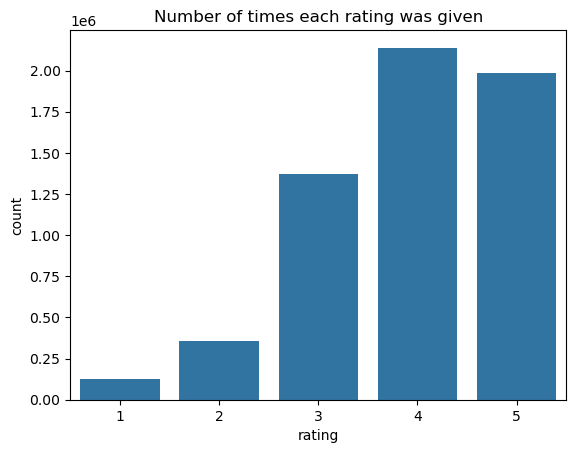

In [14]:
# Visualize the rating column using a bar plot

sns.countplot(x='rating', data=ratings)
plt.title('Number of times each rating was given')

Text(0.5, 1.0, 'Distribution of the average ratings')

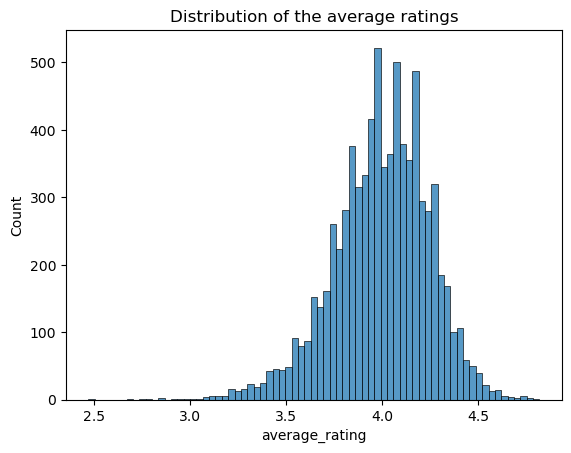

In [15]:
# Visualize the distribution of the average ratings

sns.histplot(x='average_rating', data=books_cleaned)
plt.title('Distribution of the average ratings')

In [16]:
# Find the 25 highest rated of the top most frequently rated books

frequent_books_list = frequent_books['title'].head(50).unique()

frequent_books_ratings = books_cleaned.groupby(['title'])[['average_rating']].agg('mean').reset_index()
frequent_books_ratings = frequent_books_ratings[frequent_books_ratings['title'].isin(frequent_books_list)]
frequent_books_ratings = frequent_books_ratings.sort_values('average_rating', ascending=False)
frequent_books_ratings = frequent_books_ratings.reset_index().drop(['index'], axis=1)
frequent_books_ratings = frequent_books_ratings.head(25)
frequent_books_ratings

,title,average_rating
0,Harry Potter and the Deathly Hallows (Harry Po...,4.61
1,Harry Potter and the Half-Blood Prince (Harry ...,4.54
2,Harry Potter and the Prisoner of Azkaban (Harr...,4.53
3,Harry Potter and the Goblet of Fire (Harry Pot...,4.53
4,Harry Potter and the Order of the Phoenix (Har...,4.46
5,The Help,4.45
6,"A Game of Thrones (A Song of Ice and Fire, #1)",4.45
7,Harry Potter and the Sorcerer's Stone (Harry P...,4.44
8,Harry Potter and the Chamber of Secrets (Harry...,4.37
9,The Book Thief,4.36


In [17]:
# Plot the 25 highest rated of the top most frequently rated books

fig = px.bar(frequent_books_ratings, x='average_rating', y='title', title='25 highest rated of the top most frequently rated books')
fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    width=800,
    height=800
)
fig.show()

### Problem 5: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Goodreads is a social cataloging website that allows people to find and share books. Goodreads users make and read reviews, search for books, create lists of books, create a library catalog, and get book recommendations. Considering Goodreads' purpose is to help its users find enjoyable books to read based on the users' own data and the data of similar users, a good recommendation system is important. The recommendation system ensures that the Goodreads site fulfills its purpose and gives each user unique book recommendations that they will actually enjoy. Goodreads must figure out what type of recommendation system is best for predicting the best recommendations for each user. Using recommendation systems to determine the best model, Goodreads will be able to create unique and accurate algorithms for each user. This would increase customer retention and encourage more people to join Goodreads as accurate recommendations will encourage book readers to use this website to find and share books. 

### Problem 6: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data. Using just the ratings.csv information features, prepare the features and target column for modeling with appropriate encoding and transformations.

The title and authors columns of the books dataset are merged into the ratings dataset. This is so that an item profile is built for each book. This will be especially useful for the content-based model. Then the authors and title columns are encoded as the data must be numerical to utilize in the models.

In [11]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   book_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 136.8 MB


In [12]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    10000 non-null  int64  
 1   goodreads_book_id          10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [13]:
# Create a dataframe of only the needed columns in the books dataset

titles_authors = books[['book_id', 'authors', 'title']]
titles_authors.head()

,book_id,authors,title
0,1,Suzanne Collins,"The Hunger Games (The Hunger Games, #1)"
1,2,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
2,3,Stephenie Meyer,"Twilight (Twilight, #1)"
3,4,Harper Lee,To Kill a Mockingbird
4,5,F. Scott Fitzgerald,The Great Gatsby


In [14]:
# Merge the ratings and titles_authors dataset

rated_books = pd.merge(ratings, titles_authors, on='book_id', how='inner')
rated_books.head()

,user_id,book_id,rating,authors,title
0,1,258,5,"Carlos Ruiz Zafón, Lucia Graves",The Shadow of the Wind (The Cemetery of Forgot...
1,2,4081,4,Tom Wolfe,I am Charlotte Simmons
2,2,260,5,Dale Carnegie,How to Win Friends and Influence People
3,2,9296,5,"Alice Miller, Ruth Ward",The Drama of the Gifted Child: The Search for ...
4,2,2318,3,"Thomas J. Stanley, William D. Danko",The Millionaire Next Door: The Surprising Secr...


In [15]:
# Initialize LabelEncoder

encoder = LabelEncoder()

In [16]:
# Encode the authors column

rated_books['authors_encoded'] = encoder.fit_transform(rated_books['authors'])
rated_books.head()

,user_id,book_id,rating,authors,title,authors_encoded
0,1,258,5,"Carlos Ruiz Zafón, Lucia Graves",The Shadow of the Wind (The Cemetery of Forgot...,641
1,2,4081,4,Tom Wolfe,I am Charlotte Simmons,4394
2,2,260,5,Dale Carnegie,How to Win Friends and Influence People,896
3,2,9296,5,"Alice Miller, Ruth Ward",The Drama of the Gifted Child: The Search for ...,126
4,2,2318,3,"Thomas J. Stanley, William D. Danko",The Millionaire Next Door: The Surprising Secr...,4327


In [17]:
# Encode the title column

rated_books['title_encoded'] = encoder.fit_transform(rated_books['title'])
rated_books.head()

,user_id,book_id,rating,authors,title,authors_encoded,title_encoded
0,1,258,5,"Carlos Ruiz Zafón, Lucia Graves",The Shadow of the Wind (The Cemetery of Forgot...,641,8452
1,2,4081,4,Tom Wolfe,I am Charlotte Simmons,4394,3276
2,2,260,5,Dale Carnegie,How to Win Friends and Influence People,896,3213
3,2,9296,5,"Alice Miller, Ruth Ward",The Drama of the Gifted Child: The Search for ...,126,6894
4,2,2318,3,"Thomas J. Stanley, William D. Danko",The Millionaire Next Door: The Surprising Secr...,4327,7860


In [18]:
# Delete the original authors and title columns

rated_books = rated_books.drop(columns=['authors', 'title'])

In [19]:
# Reset the index of the rated_books dataset

rated_books = rated_books.reset_index()
rated_books.head()

,index,user_id,book_id,rating,authors_encoded,title_encoded
0,0,1,258,5,641,8452
1,1,2,4081,4,4394,3276
2,2,2,260,5,896,3213
3,3,2,9296,5,126,6894
4,4,2,2318,3,4327,7860


### Problem 7: Train/Test Split

With your data prepared, split it into a train and test set.

In [20]:
# Split the data into the training sets and test sets

X = rated_books[["user_id", "book_id", "authors_encoded", "title_encoded"]]
y = rated_books["rating"]

# Ensure reproducibility
random_seed = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [21]:
# Reset the indices 

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

### Problem 8: A Popularity-Based Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [29]:
# Create a popularity-based Recommendatation System

# Record the start time 
pop_start_time = time.time()

# Calculate book popularity 
book_popularity = X_train.groupby('book_id').size().sort_values(ascending=False)

# Get the top most popular books
top_popular_books = book_popularity.index.tolist()

# Record the end time 
pop_end_time = time.time()
pop_elapsed_time = pop_end_time - pop_start_time
print(f"Baseline training time: {pop_elapsed_time} seconds")

Baseline training time: 0.044120073318481445 seconds


In [30]:
# Baseline model: Make recommendations and define the evaluation model
def evaluate_recommendations(X_test, y_test, top_popular_books):
    y_true = []
    y_pred = []
    
    for _, row in X_test.iterrows():
        y_true.append(row['book_id'])
        y_pred.append(top_popular_books[0])
    
# Precision and Recall evaluation
    return precision_score(y_true, y_pred, average='micro'), recall_score(y_true, y_pred, average='micro')



In [31]:
# Evaluate the model
precision, recall = evaluate_recommendations(X_test, y_test, top_popular_books)

print(f'Baseline Precision: {precision}')
print(f'Baseline Recall: {recall}')

Baseline Precision: 0.0037756338178994995
Baseline Recall: 0.0037756338178994995


### Problem 9: Content-Based Recommendatation Systems

Compare multiple content-based models and find the best performing one to use for the hybrid recommendation system.

### Create a Random Forests Content-Based Recommendatation System

In [32]:
# Create a Random Forests Content-Based Recommendatation System

# Record the start time 
rf_start_time = time.time()

# Train and Fit the Model
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Record the end time 
rf_end_time = time.time()
rf_elapsed_time = rf_end_time - rf_start_time
print(f"Random Forests training time: {rf_elapsed_time} seconds")

Random Forests training time: 10.09120488166809 seconds


In [33]:
# Make predictions with the random forests classifier recommendation system

rf_pred = rf_model.predict(X_test)

In [34]:
# Define thresholds for rating categories
def rating_to_category(rating):
    if rating >= 4.0:
        return 'High'
    elif rating >= 2.5:
        return 'Medium'
    else:
        return 'Low'

# Convert true ratings and predicted ratings to categories
y_test_categories = y_test.apply(rating_to_category)
rf_pred_categories = pd.Series(rf_pred).apply(rating_to_category)

print("True categories:", y_test_categories)
print("Predicted categories:", rf_pred_categories)

True categories: 3623535    Medium
3985638      High
2983642      High
5812251       Low
2208852      High
            ...  
5145558      High
2509373      High
1806767      High
172718       High
622357     Medium
Name: rating, Length: 1195296, dtype: object
Predicted categories: 0          High
1          High
2          High
3          High
4          High
           ... 
1195291    High
1195292    High
1195293    High
1195294    High
1195295    High
Length: 1195296, dtype: object


In [35]:
# Evaluate the Random Forests Recommendation System Using Precision and Recall
rf_precision = precision_score(y_test_categories, rf_pred_categories, average='weighted', labels=['High', 'Medium', 'Low'])
rf_recall = recall_score(y_test_categories, rf_pred_categories, average='weighted', labels=['High', 'Medium', 'Low'])

print(f"Random Forests Precision: {rf_precision}")
print(f"Random Forests Recall: {rf_recall}")

Random Forests Precision: 0.5769013682253742
Random Forests Recall: 0.6889289347575831


### Create an ANNOY Content-Based Recommendatation System

In [36]:
# Set feture dimensions 

feature_dim = 2

# Normalize features for better distance calculations
scaler = MinMaxScaler()
X_train[['authors_encoded', 'title_encoded']] = scaler.fit_transform(X_train[['authors_encoded', 'title_encoded']])
X_test[['authors_encoded', 'title_encoded']] = scaler.transform(X_test[['authors_encoded', 'title_encoded']])


In [37]:
# Create and Train an ANNOY Content-Based Recommendatation System

# Record the start time 
ai_start_time = time.time()

# Create ANNOY index
annoy_index = AnnoyIndex(feature_dim, 'euclidean')

# Build ANNOY Index
book_to_idx = {} 
idx_to_book = {} 

for i, (book_id, row) in enumerate(X_train.set_index('book_id')[['authors_encoded', 'title_encoded']].iterrows()):
    annoy_index.add_item(i, row.values)
    book_to_idx[book_id] = i
    idx_to_book[i] = book_id

# Build the index
annoy_index.build(10)

# Record the end time 
ai_end_time = time.time()
ai_elapsed_time = ai_end_time - ai_start_time
print(f"ANNOY training time: {ai_elapsed_time} seconds")

ANNOY training time: 65.30061960220337 seconds


In [38]:
# Make Predictions with the ANNOY Index
def get_top_n_recommendations(book_id, annoy_index, X_train, n=5):
    if book_id not in book_to_idx:
        return []
    
    idx = book_to_idx[book_id]
    nearest_indices = annoy_index.get_nns_by_item(idx, n+1)[1:]
    return [idx_to_book[i] for i in nearest_indices]


In [39]:
# Evaluate the ANNOY Recommendation System

# Set up the Evaluation Metric
def evaluate_recommendations(X_test, y_test, annoy_index, X_train, n=5):
    precision_list = []
    recall_list = []
    
    for i in X_test.index:
        book_id = X_test.at[i, 'book_id']
        
        # Get top N recommendations
        top_n_books = get_top_n_recommendations(book_id, annoy_index, X_train, n)
        
        # Get user’s liked books (ratings ≥ 4)
        liked_books = y_test.iloc[i]

        # Convert to NumPy array if needed
        if isinstance(liked_books, pd.Series):
            liked_books = liked_books.values

        # Use boolean filtering instead of np.where()
        liked_books = list(liked_books[liked_books >= 4])

        # Compute precision and recall
        if liked_books:
            true_relevance = sum(1 for book in top_n_books if book in liked_books)
            precision = true_relevance / len(top_n_books) if top_n_books else 0
            recall = true_relevance / len(liked_books) if liked_books else 0
        else:
            precision = 0
            recall = 0
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    # Compute average precision and recall
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    
    return avg_precision, avg_recall

# Run evaluation
avg_precision, avg_recall = evaluate_recommendations(X_test, y_test, annoy_index, X_train, n=5)
print(f"ANNOY Average Precision: {avg_precision:.4f}")
print(f"ANNOY Average Recall: {avg_recall:.4f}")

ANNOY Average Precision: 0.0019
ANNOY Average Recall: 0.0093


### Create a HNSW Content-Based Recommendation System

In [28]:
# Remove book_id and user_id from features
X_train_filtered = X_train.drop(columns=["book_id", "user_id"]).values
X_test_filtered = X_test.drop(columns=["book_id", "user_id"]).values

# Store book IDs separately
book_id_train = X_train["book_id"].values  
book_id_test = X_test["book_id"].values  

# Extract ratings
y_train = y_train.values
y_test = y_test.values  

In [29]:
# Create and Train an HNSW Content-Based Recommendatation System

# Record the start time 
hnsw_start_time = time.time()

def build_hnsw_index(X_train_filtered):
    dim = X_train_filtered.shape[1]
    num_elements = X_train_filtered.shape[0] 
    
    # Initialize HNSW index with optimized parameters
    hnsw = hnswlib.Index(space="l2", dim=dim)
    hnsw.init_index(max_elements=num_elements, ef_construction=100, M=8) 
    hnsw.add_items(X_train_filtered, np.arange(num_elements)) 
    
    # Optimize query time parameters
    hnsw.set_ef(10) 
    
    # Save index for reuse
    hnsw.save_index("hnsw_index.bin")
    
    return hnsw

# If the index exists, load it instead of rebuilding
try:
    hnsw_index = hnswlib.Index(space="l2", dim=X_train_filtered.shape[1])
    hnsw_index.load_index("hnsw_index.bin", max_elements=X_train_filtered.shape[0])
    print("Loaded existing HNSW index.")
except:
    print("⚠️ No saved index found. Building a new one...")
    hnsw_index = build_hnsw_index(X_train_filtered)

# Record the end time 
hnsw_end_time = time.time()
hnsw_elapsed_time = hnsw_end_time - hnsw_start_time
print(f"HNSW training time: {hnsw_elapsed_time} seconds")

Loaded existing HNSW index.
HNSW training time: 14.75098180770874 seconds


In [30]:
# Make Predictions

def get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n=5):
    labels, _ = hnsw_index.knn_query(book_vector, k=n)
    recommended_book_ids = book_id_train[labels.flatten()]
    return list(set(recommended_book_ids))

In [31]:
# Set up Evaluation

def evaluate_hnsw(X_test_filtered, y_test, hnsw_index, book_id_test, book_id_train, n=5):
    precision_list = []
    recall_list = []
    
    for i in range(len(X_test_filtered)):
        book_vector = X_test_filtered[i].reshape(1, -1)  # Ensure correct shape

        # Generate recommendations
        top_n_books = get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n)

        # Extract user's liked books (rating ≥ 4)
        liked_books = [book_id_test[i]] if y_test[i] >= 4 else []  

        # Compute Precision and Recall
        true_relevance = sum(1 for book in set(top_n_books) if book in liked_books)
        precision = true_relevance / len(top_n_books) if len(top_n_books) > 0 else 0
        recall = true_relevance / max(len(liked_books), 1)

        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(precision_list), np.mean(recall_list)

In [32]:
if __name__ == "__main__":
    # Train HNSW Index
    hnsw_index = build_hnsw_index(X_train_filtered)

    # Evaluate the model
    avg_precision, avg_recall = evaluate_hnsw(X_test_filtered, y_test, hnsw_index, book_id_test, book_id_train, n=5)

    # Print results
    print(f"HNSW Average Precision: {avg_precision:.4f}")
    print(f"HNSW Average Recall: {avg_recall:.4f}")

HNSW Average Precision: 0.5236
HNSW Average Recall: 0.5244


### Problem 10: Collaborative-Based Recommendatation Systems

Compare multiple collaborative-based models and find the best performing one to use for the hybrid recommendation system.

In [33]:
# Set up the data 
# Define the reader format for the dataset
reader = Reader(rating_scale=(1, 5)) 

# Ensure y_train and y_test are Pandas Series
y_train = pd.Series(y_train, name="rating")
y_test = pd.Series(y_test, name="rating")

# Reconstruct train dataset
train_data = pd.concat([X_train, y_train], axis=1)  

data = Dataset.load_from_df(train_data[['user_id', 'book_id', 'rating']], reader)
trainset = data.build_full_trainset()

# Reconstruct test dataset (Surprise requires a list of (user, item, rating) tuples)
test_data = pd.concat([X_test, y_test], axis=1) 
testset = test_data[['user_id', 'book_id', 'rating']].to_records(index=False).tolist()

In [46]:
# Define algorithm classes
algo_classes = {
    'KNNBasic': KNNBasic,
    'SVD': SVD,
    'NMF': NMF,
    'CoClustering': CoClustering
}

# Set up algorithm parameters
param_dists = {
    'KNNBasic': {
        'k': randint(20, 41),
        'min_k': randint(1, 6),
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson'],
            'user_based': [False, True] 
        }
    },
    'SVD': {
        'n_factors': randint(50, 151),
        'n_epochs': randint(20, 31),
        'lr_all': uniform(0.001, 0.01),
        'reg_all': uniform(0.02, 0.03)
    },
    'NMF': {
        'n_factors': randint(10, 31),
        'n_epochs': randint(20, 51),
        'biased': [False, True]
    },
    'CoClustering': {
        'n_cltr_u': randint(3, 8),
        'n_cltr_i': randint(3, 8),
        'n_epochs': randint(20, 31)
    }
}

In [47]:
# Perform randomized search for each algorithm and measure training time
best_algorithms = {}
training_times = {}
testing_times = {}

for algo_name, param_dist in param_dists.items():
    start_time = time.time()
    
    # Reduce dataset before training by ensuring only three columns: (user_id, book_id, rating)
    small_data = Dataset.load_from_df(train_data[['user_id', 'book_id', 'rating']].sample(n=5000, random_state=42), reader)

    # Perform Randomized Search CV with small dataset (before building trainset)
    rs = RandomizedSearchCV(algo_classes[algo_name], param_dist, measures=['rmse'], cv=3, n_iter=5, random_state=42, n_jobs=1)
    rs.fit(small_data)
    
    end_time = time.time()
    
    # Store the best algorithm
    best_algorithms[algo_name] = rs.best_estimator['rmse'] 
    training_times[algo_name] = end_time - start_time
    testing_times[algo_name] = 0 
    
    print(f"Best parameters for {algo_name}: {rs.best_params['rmse']}")
    print(f"Training time for {algo_name}: {training_times[algo_name]:.2f} seconds\n")

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Co

In [48]:
# Add SlopeOne as it has no parameters to tune
best_algorithms['SlopeOne'] = SlopeOne()
training_times['SlopeOne'] = 0
testing_times['SlopeOne'] = 0

# Perform cross-validation for the best algorithms found and measure training/testing times
results = {}

In [49]:
# Function to compute precision and recall at k
def precision_recall_at_k(predictions, k=5, threshold=4.0):
    user_est_true = defaultdict(list)

    # Map predictions to each user
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = {}
    recalls = {}

    for uid, user_ratings in user_est_true.items():
        # Sort predictions by estimated rating in descending order
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Count relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        # Count recommended items in top-k
        n_rec_k = sum((true_r >= threshold) for (_, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rec_k / k if k else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rec_k / n_rel if n_rel else 1

    # Average precision and recall across users
    precision = sum(precisions.values()) / len(precisions)
    recall = sum(recalls.values()) / len(recalls)

    return precision, recall


In [50]:
# Evaluate the best algorithms on Precision and Recall
results = {}

for algo_name, best_algo in best_algorithms.items():
    print(f"Evaluating {algo_name} with best parameters...")

    # Train the model
    best_algo.fit(trainset)

    # Make predictions on the test set
    predictions = best_algo.test(testset)

    # Compute precision and recall
    precision, recall = precision_recall_at_k(predictions, k=5)

    results[algo_name] = {'precision': precision, 'recall': recall}

    print(f"Precision@5 for {algo_name}: {precision:.4f}")
    print(f"Recall@5 for {algo_name}: {recall:.4f}")

# Find the best algorithms based on Precision and Recall
optimal_algo_precision = max(results, key=lambda x: results[x]['precision'])
optimal_algo_recall = max(results, key=lambda x: results[x]['recall'])

# Print the best algorithms
print("\nOptimal Algorithm (Precision):", optimal_algo_precision, "with Precision:", results[optimal_algo_precision]['precision'])
print("Optimal Algorithm (Recall):", optimal_algo_recall, "with Recall:", results[optimal_algo_recall]['recall'])

print("Training time for the optimal algorithm: {:.2f} seconds".format(training_times[optimal_algo_precision]))
print("Testing time for the optimal algorithm: {:.2f} seconds".format(testing_times[optimal_algo_precision]))

Evaluating KNNBasic with best parameters...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Precision@5 for KNNBasic: 0.7733
Recall@5 for KNNBasic: 0.2838
Evaluating SVD with best parameters...
Precision@5 for SVD: 0.8197
Recall@5 for SVD: 0.3033
Evaluating NMF with best parameters...
Precision@5 for NMF: 0.7954
Recall@5 for NMF: 0.2928
Evaluating CoClustering with best parameters...
Precision@5 for CoClustering: 0.8100
Recall@5 for CoClustering: 0.2988
Evaluating SlopeOne with best parameters...
Precision@5 for SlopeOne: 0.8185
Recall@5 for SlopeOne: 0.3029

Optimal Algorithm (Precision): SVD with Precision: 0.8196731744754132
Optimal Algorithm (Recall): SVD with Recall: 0.30330399328311425
Training time for the optimal algorithm: 0.53 seconds
Testing time for the optimal algorithm: 0.00 seconds


      Algorithm  Mean Precision  Mean Recall  Training Time (s)  \
0      KNNBasic        0.773337     0.283849           1.030449   
1           SVD        0.819673     0.303304           0.530413   
2           NMF        0.795358     0.292762           3.415733   
3  CoClustering        0.810033     0.298764           3.465509   
4      SlopeOne        0.818468     0.302893           0.000000   

   Testing Time (s)  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  


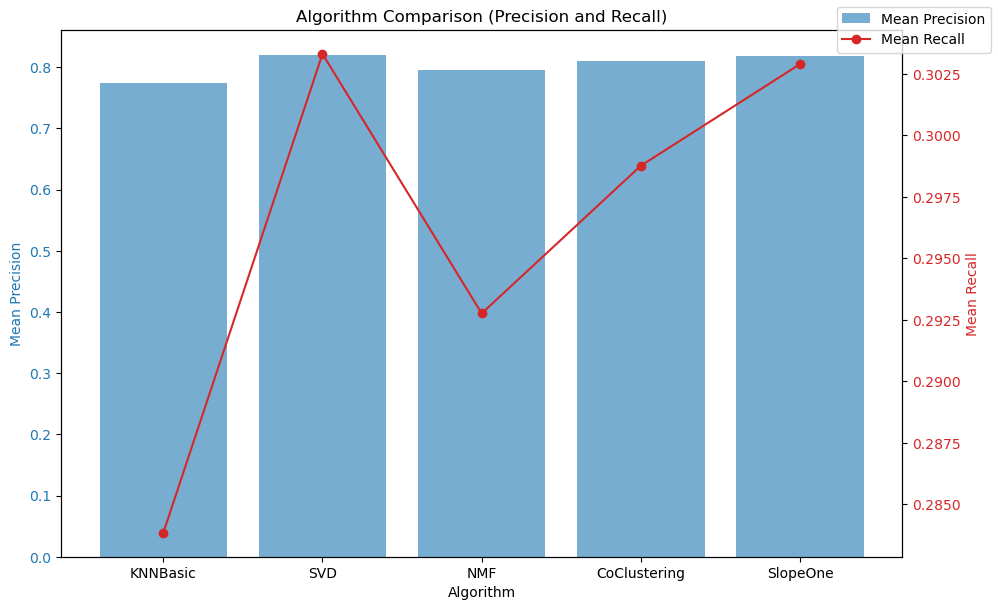

In [51]:
# Create a DataFrame to display the precision and recall results
df_results = pd.DataFrame({
    'Algorithm': list(results.keys()),  # Use algorithms from results
    'Mean Precision': [results[algo]['precision'] for algo in results],
    'Mean Recall': [results[algo]['recall'] for algo in results],
    'Training Time (s)': [training_times.get(algo, 0) for algo in results],
    'Testing Time (s)': [testing_times.get(algo, 0) for algo in results]
})

# Display the DataFrame
print(df_results)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Mean Precision', color=color)
ax1.bar(df_results['Algorithm'], df_results['Mean Precision'], color=color, alpha=0.6, label='Mean Precision')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Mean Recall', color=color)  
ax2.plot(df_results['Algorithm'], df_results['Mean Recall'], color=color, marker='o', label='Mean Recall')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper right')
plt.title('Algorithm Comparison (Precision and Recall)')
plt.show()

### SlopeOne Collaborative-Based Recommendation System

I've chosen to use the SlopeOne Collaborative-Based Recommendation System for the hybrid recommendation system. Now I will train the SlopeOne model on the entire dataset.

In [34]:
# Define the reader format for the dataset
reader = Reader(rating_scale=(1, 5))  

# Ensure y_train and y_test are Pandas Series
y_train = pd.Series(y_train, name="rating")
y_test = pd.Series(y_test, name="rating")

# Reconstruct train dataset (entire dataset)
train_data = pd.concat([X_train, y_train], axis=1)  
data = Dataset.load_from_df(train_data[['user_id', 'book_id', 'rating']], reader)
trainset = data.build_full_trainset()  

# Reconstruct test dataset
test_data = pd.concat([X_test, y_test], axis=1)  
testset = test_data[['user_id', 'book_id', 'rating']].to_records(index=False).tolist()

# Initialize and train the SlopeOne model

slopeone_start_time = time.time()

slopeone = SlopeOne()
slopeone.fit(trainset)

slopeone_end_time = time.time()
slopeone_elapsed_time = slopeone_end_time - slopeone_start_time

# Function to compute Precision and Recall @K
def precision_recall_at_k(predictions, k=5, threshold=4.0):
    user_est_true = defaultdict(list)

    # Map predictions to each user
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls = {}, {}

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((true_r >= threshold) for (_, true_r) in user_ratings[:k])

        precisions[uid] = n_rec_k / k if k else 1
        recalls[uid] = n_rec_k / n_rel if n_rel else 1

    precision = sum(precisions.values()) / len(precisions)
    recall = sum(recalls.values()) / len(recalls)

    return precision, recall

# Evaluate SlopeOne on the test set
testing_start_time = time.time()

predictions = slopeone.test(testset)
precision, recall = precision_recall_at_k(predictions, k=5)

testing_end_time = time.time()
testing_elapsed_time = testing_end_time - testing_start_time

# Print results
print(f"SlopeOne Precision@5: {precision:.4f}")
print(f"SlopeOne Recall@5: {recall:.4f}")
print(f"SlopeOne Training Time: {slopeone_elapsed_time:.2f} seconds")
print(f"SlopeOne training time: {testing_elapsed_time} seconds")

SlopeOne Precision@5: 0.8185
SlopeOne Recall@5: 0.3029
SlopeOne Training Time: 19.60 seconds
SlopeOne training time: 61.55986022949219 seconds


### Problem 11: Hybrid Recommendatation Systems

Compare multiple hybrid models (content and collaborative-based recommendation systems) and find the best performing one for Goodreads to use. I will use the HNSW content-based model and the SlopeOne collaborative-based model.

### Create a Weighted Hybrid Recommendation System

In [53]:
# Create a weighted hybrid model

# Record start time
weighted_start_time = time.time()

def hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone_model, n=5, alpha=0.5):
  
    # Get More Content-Based Recommendations from HNSW
    try:
        content_rec_books = get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n * 50)
    except Exception as e:
        return []

    if not content_rec_books:
        print("No books retrieved from content-based filtering. Using collaborative filtering only.")
        return [slopeone_model.predict(user_id, book_id).iid for book_id in book_id_train[:n]]


    # Get Collaborative Scores
    collaborative_scores = {}
    for book_id in content_rec_books:
        pred = slopeone_model.predict(user_id, book_id)
        collaborative_scores[book_id] = pred.est if pred else np.mean(list(collaborative_scores.values()))


    # Normalize Scores
    max_collab = max(collaborative_scores.values(), default=1)
    min_collab = min(collaborative_scores.values(), default=1)

    if max_collab == min_collab:
        normalized_collab_scores = {book_id: 0.5 for book_id in content_rec_books}
    else:
        normalized_collab_scores = {
            book_id: (collaborative_scores[book_id] - min_collab) / (max_collab - min_collab + 1e-6)
            for book_id in content_rec_books
        }

    content_scores = {book_id: 1 - i / len(content_rec_books) for i, book_id in enumerate(content_rec_books)}

    hybrid_scores = {
        book_id: alpha * content_scores[book_id] + (1 - alpha) * normalized_collab_scores[book_id]
        for book_id in content_rec_books
    }

    # Get Top N Books
    sorted_books = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:n]
    final_recommendations = [book_id for book_id, _ in sorted_books]

    return final_recommendations
# Record the end time 
weighted_end_time = time.time()
weighted_elapsed_time = weighted_end_time - weighted_start_time
print(f"Weighted training time: {weighted_elapsed_time} seconds")

Weighted training time: 0.00017881393432617188 seconds


In [54]:
# Evaluate the weighted model

def evaluate_hybrid_optimized(
    X_test_filtered, y_test, user_ids, hnsw_index, book_id_train, slopeone_model, 
    n=5, alpha=0.5, sample_size=1000 
):
    precision_list = []
    recall_list = []
    
    indices = random.sample(range(len(X_test_filtered)), min(sample_size, len(X_test_filtered)))

    for i in indices:
        user_id = user_ids[i] 
        book_vector = X_test_filtered[i].reshape(1, -1)  

        # Generate Hybrid Recommendations
        top_n_books = hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone_model, n, alpha)

        # Extract User's Liked Books (rating ≥ 4)
        liked_books = [book_id_test[i]] if y_test[i] >= 4 else []

        # Compute Precision and Recall
        true_relevance = sum(1 for book in set(top_n_books) if book in liked_books)
        precision = true_relevance / len(top_n_books) if len(top_n_books) > 0 else 0
        recall = true_relevance / max(len(liked_books), 1)

        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(precision_list), np.mean(recall_list)


# Run Optimized Evaluation
avg_precision, avg_recall = evaluate_hybrid_optimized(
    X_test_filtered, y_test, X_test["user_id"].values, hnsw_index, book_id_train, slopeone, 
    n=5, alpha=0.5, sample_size=1000 
)

# Print Results
print(f"Weighted Hybrid Model Precision: {avg_precision:.4f}")
print(f"Weighted Hybrid Model Recall: {avg_recall:.4f}")

Weighted Hybrid Model Precision: 0.3663
Weighted Hybrid Model Recall: 0.5350


### Create a Switching Hybrid Recommendation System

In [55]:
# Create a switching hybrid recomme

# Record start time
switching_start_time = time.time()

def switching_hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone_model, user_history, n=5, rating_threshold=3):
    # Check if the user has enough historical ratings for collaborative filtering
    if user_id in user_history and len(user_history[user_id]) >= rating_threshold:
        # Use collaborative filtering (SlopeOne)
        recommended_books = []
        for book_id in book_id_train:
            pred = slopeone_model.predict(user_id, book_id)
            recommended_books.append((book_id, pred.est))

        # Sort by predicted rating and return top N recommendations
        recommended_books.sort(key=lambda x: x[1], reverse=True)
        return [book_id for book_id, _ in recommended_books[:n]]

    else:
        # Use content-based filtering (HNSW)
        return get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n)

# Record the end time 
switching_end_time = time.time()
switching_elapsed_time = switching_end_time - switching_start_time
print(f"Switching training time: {switching_elapsed_time} seconds")

Switching training time: 9.179115295410156e-05 seconds


In [56]:
# Set up evaluation

def evaluate_switching_hybrid(X_test_filtered, y_test, book_id_test, user_ids, hnsw_index, book_id_train, slopeone_model, user_history, n=5, rating_threshold=3):
    precision_list = []
    recall_list = []

    for i in range(len(user_ids)):  # Iterate over all users in the test set
        user_id = user_ids[i]  # Get the current user ID
        book_vector = np.array(X_test_filtered.iloc[i]).reshape(1, -1) 

        # Generate recommendations
        top_n_books = switching_hybrid_recommender(
            user_id, book_vector, hnsw_index, book_id_train, slopeone_model, user_history, n, rating_threshold
        )

        # Extract user's liked books (rating ≥ 4)
        liked_books = [book_id_test.iloc[i]] if y_test.iloc[i] >= 4 else []

        # Compute Precision and Recall
        true_relevance = sum(1 for book in set(top_n_books) if book in liked_books)
        precision = true_relevance / len(top_n_books) if len(top_n_books) > 0 else 0
        recall = true_relevance / max(len(liked_books), 1)

        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(precision_list), np.mean(recall_list)

In [57]:
# Ensure X_test_filtered is a DataFrame
if isinstance(X_test_filtered, np.ndarray):
    X_test_filtered = pd.DataFrame(X_test_filtered)

# Reduce test sample size
X_test_sample = X_test.sample(n=100, random_state=42)  
X_test_filtered_sample = X_test_filtered.iloc[X_test_sample.index]  

# Optimize indexing
user_ids = X_test_sample["user_id"].values  
book_id_test_sample = X_test_sample["book_id"].reset_index(drop=True)
y_test_sample = y_test.loc[X_test_sample.index].reset_index(drop=True)

# Ensure user_history is properly loaded
if 'user_history' not in globals():
    user_history = {}

# Speed up HNSW search
hnsw_index.set_ef(50)  # Reduce ef for faster queries

# Safe wrapper function
def evaluate_switching_hybrid_safe(*args, **kwargs):
    try:
        result = evaluate_switching_hybrid(*args, **kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            return result
        else:
            print("⚠️ Unexpected return type from evaluate_switching_hybrid. Using (0, 0)")
            return (0, 0)
    except Exception as e:
        print(f"⚠️ Error in evaluate_switching_hybrid: {e}")
        return (0, 0) 

# Run evaluation in parallel
results = Parallel(n_jobs=4)(
    delayed(evaluate_switching_hybrid_safe)(
        X_test_filtered_sample, y_test_sample, book_id_test_sample, user_ids, 
        hnsw_index, book_id_train, slopeone, user_history, n=5
    )
    for _ in range(1) 
)

# Extract values correctly
if results and isinstance(results[0], tuple):
    avg_precision, avg_recall = results[0]
else:
    avg_precision, avg_recall = 0, 0 

# Print final results
print(f"Switching Average Precision: {avg_precision:.4f}")
print(f"Switching Average Recall: {avg_recall:.4f}")

Switching Average Precision: 0.6300
Switching Average Recall: 0.6300


### Create a Mixed Hybrid Recommendation System

In [58]:
# Record start time
mixed_start_time = time.time()

# Hybrid Recommendation Function
def hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n=5):
    # Step 1: Content-Based Recommendations
    top_n_books = get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n=n * 2)  # Get more books initially
    
    # Step 2: Collaborative Filtering - Predict Ratings
    book_ratings = {}
    for book_id in top_n_books:
        pred = slopeone.predict(user_id, book_id).est 
        book_ratings[book_id] = pred
    
    # Step 3: Sort by Predicted Ratings and Select Top-N
    ranked_books = sorted(book_ratings, key=book_ratings.get, reverse=True)[:n]
    
    return ranked_books

# Record the end time 
mixed_end_time = time.time()
mixed_elapsed_time = mixed_end_time - mixed_start_time
print(f"Mixed training time: {mixed_elapsed_time} seconds")

Mixed training time: 8.487701416015625e-05 seconds


In [59]:
# Hybrid Evaluation Function
def evaluate_hybrid(X_test, y_test, hnsw_index, book_id_test, book_id_train, slopeone, n=5):
    precision_list, recall_list = [], []
    
    for i in range(len(X_test)):
        user_id = X_test.iloc[i]['user_id']
        book_vector = X_test_filtered.iloc[i].values.reshape(1, -1) 
        
        # Generate Hybrid Recommendations
        recommended_books = hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n)
        
        # Extract Ground Truth (Liked Books)
        liked_books = [book_id_test[i]] if y_test[i] >= 4 else []
        
        # Compute Precision and Recall
        true_relevance = sum(1 for book in set(recommended_books) if book in liked_books)
        precision = true_relevance / len(recommended_books) if recommended_books else 0
        recall = true_relevance / max(len(liked_books), 1)
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    return np.mean(precision_list), np.mean(recall_list)

In [60]:
# Run Hybrid Recommender
if __name__ == "__main__":
    # Train HNSW
    hnsw_index = build_hnsw_index(X_train_filtered)
    
    # Evaluate Hybrid Model
    avg_precision, avg_recall = evaluate_hybrid(X_test, y_test, hnsw_index, book_id_test, book_id_train, slopeone, n=5)
    
    # Print Results
    print(f"Mixed Hybrid Average Precision: {avg_precision:.4f}")
    print(f"Mixed Hybrid Average Recall: {avg_recall:.4f}")


Mixed Hybrid Average Precision: 0.5527
Mixed Hybrid Average Recall: 0.5549


### Create a Cascade Hybrid Recommendation System

In [61]:
# Record start time
cascade_start_time = time.time()

def cascade_hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n=5):
    # Use HNSW to get top N candidate books
    candidate_books = get_top_n_recommendations(book_vector, hnsw_index, book_id_train, n * 2)

    # Predict ratings with SlopeOne and rank them
    book_ratings = []
    for book_id in candidate_books:
        pred = slopeone.predict(uid=user_id, iid=book_id)
        book_ratings.append((book_id, pred.est))

    # Sort by predicted ratings and return top N
    book_ratings.sort(key=lambda x: x[1], reverse=True)
    top_books = [book[0] for book in book_ratings[:n]] 

    return top_books

# Record the end time 
cascade_end_time = time.time()
cascade_elapsed_time = cascade_end_time - cascade_start_time
print(f"Cascade training time: {cascade_elapsed_time} seconds")

Cascade training time: 8.606910705566406e-05 seconds


In [62]:
# Evaluation function
def evaluate_cascade_hybrid(X_test, y_test, hnsw_index, book_id_test, book_id_train, slopeone, n=5):
    precision_list, recall_list = [], []

    for i in range(len(X_test)):
        user_id = X_test.iloc[i]['user_id']
        book_vector = np.array(X_test_filtered.iloc[i]).reshape(1, -1) 

        # Generate recommendations using the cascade hybrid approach
        recommended_books = cascade_hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n)

        # Extract user's liked books (rating ≥ 4)
        liked_books = [book_id_test[i]] if y_test[i] >= 4 else []

        # Compute Precision and Recall
        true_relevance = sum(1 for book in recommended_books if book in liked_books)
        precision = true_relevance / len(recommended_books) if recommended_books else 0
        recall = true_relevance / max(len(liked_books), 1)

        precision_list.append(precision)
        recall_list.append(recall)

    return np.mean(precision_list), np.mean(recall_list)

In [63]:
# Run the cascade hybrid system
if __name__ == "__main__":
    # Train HNSW
    hnsw_index = build_hnsw_index(X_train_filtered)

    # Evaluate Cascade Hybrid Model
    avg_precision, avg_recall = evaluate_cascade_hybrid(X_test, y_test, hnsw_index, book_id_test, book_id_train, slopeone, n=5)

    # Print Results
    print(f"Cascade Hybrid Average Precision: {avg_precision:.4f}")
    print(f"Cascade Hybrid Average Recall: {avg_recall:.4f}")

Cascade Hybrid Average Precision: 0.5454
Cascade Hybrid Average Recall: 0.5478


### Create a Feature Hybrid Recommendation System

In [35]:
X_test_sample = X_test.iloc[:1000]
y_test_sample = y_test.iloc[:1000]

In [38]:
# Record start time
feature_start_time = time.time()

def build_hnsw_index(X_train):
    dim = X_train.shape[1]
    num_elements = X_train.shape[0]

    hnsw = hnswlib.Index(space="l2", dim=dim)
    hnsw.init_index(max_elements=num_elements, ef_construction=200, M=32)  
    hnsw.add_items(X_train, np.arange(num_elements))
    hnsw.set_ef(200)
    
    return hnsw

# Faster HNSW Recommendations
def get_hnsw_recommendations(book_vector, hnsw_index, book_id_train, n=5):
    labels, _ = hnsw_index.knn_query(book_vector, k=n)
    
    return book_id_train[labels.flatten()].tolist() if labels.size else []


In [39]:
# Function to train and predict using SlopeOne
def train_slopeone(X_train, y_train):
    reader = Reader(rating_scale=(1, 5))
    dataset = Dataset.load_from_df(pd.concat([X_train, pd.Series(y_train, name="rating")], axis=1)[['user_id', 'book_id', 'rating']], reader)
    
    slopeone = SlopeOne()
    slopeone.fit(dataset.build_full_trainset())
    return slopeone

# Faster SlopeOne Predictions
def get_slopeone_predictions(user_id, book_ids, slopeone):
    return [pred.iid for pred in sorted(slopeone.test([(user_id, book_id, 0) for book_id in book_ids]), key=lambda pred: pred.est, reverse=True)]

In [40]:
# Hybrid recommendation function
def feature_hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n=5):
    content_recs = get_hnsw_recommendations(book_vector, hnsw_index, book_id_train, n*2)
    
    if len(set(content_recs)) < 3:
        content_recs = np.random.choice(book_id_train, n, replace=False).tolist()
    
    final_recs = get_slopeone_predictions(user_id, content_recs, slopeone)[:n]
    
    return final_recs

# Record the end time 
feature_end_time = time.time()
feature_elapsed_time = feature_end_time - feature_start_time
print(f"Feature training time: {feature_elapsed_time} seconds")

Feature training time: 5.936434984207153 seconds


In [41]:
# Set up the evaluation
def evaluate_feature_hybrid(X_test_sample, y_test_sample, hnsw_index, book_id_test, book_id_train, slopeone, n=5, batch_size=100):
    X_test_sample_np = X_test_sample.drop(columns=['user_id']).to_numpy()
    y_test_sample_np = y_test_sample.to_numpy()
    book_id_test_sample_np = np.array(book_id_test[:len(X_test_sample)]) 

    def process_batch(start_idx, end_idx):
        batch_results = []
        for i in range(start_idx, end_idx):
            user_id = X_test_sample.iloc[i]['user_id']
            book_vector = X_test_sample_np[i].reshape(1, -1)

            recommended_books = feature_hybrid_recommender(user_id, book_vector, hnsw_index, book_id_train, slopeone, n)
            liked_books = [book_id_test_sample_np[i]] if y_test_sample_np[i] >= 4 else []

            true_relevance = np.isin(recommended_books, liked_books).sum()
            precision = true_relevance / len(recommended_books) if recommended_books else 0
            recall = true_relevance / max(len(liked_books), 1)

            batch_results.append((precision, recall))
        
        return batch_results

    num_samples = len(X_test_sample)
    num_batches = (num_samples + batch_size - 1) // batch_size  

    all_results = Parallel(n_jobs=-1)(
        delayed(process_batch)(i * batch_size, min((i + 1) * batch_size, len(X_test_sample)))
        for i in range((len(X_test_sample) + batch_size - 1) // batch_size)
    )

    # Now, unpack correctly
    all_results_flat = [item for sublist in all_results for item in sublist]
    if all_results_flat:
        precisions, recalls = zip(*all_results_flat)
    else:
        precisions, recalls = [], []

    return np.mean(precisions) if precisions else 0, np.mean(recalls) if recalls else 0, book_id_test_sample_np

In [42]:
# Train models
hnsw_index = build_hnsw_index(X_train_filtered)
slopeone = train_slopeone(X_train, y_train)

# Evaluate Model (Batched Processing)
avg_precision, avg_recall, book_id_test_sample_np = evaluate_feature_hybrid(
    X_test_sample, y_test_sample, hnsw_index, book_id_test, book_id_train, slopeone, n=5, batch_size=100
)

# Print results
print(f"Feature Hybrid Average Precision: {avg_precision:.4f}")
print(f"Feature Hybrid Average Recall: {avg_recall:.4f}")

Feature Hybrid Average Precision: 0.0004
Feature Hybrid Average Recall: 0.0020
